# TutorTask72 Wildlife Image Classification
**Tool:** Custom JAX/Flax workflow | **Dataset:** Animals-10

This is notebook loads the entire Animals-10 dataset, trains the SimpleCNN for multiple epochs, records quantitative metrics, runs a hyper-parameter sweep on a smaller subset, and generates every visualization that lands under `outputs/`. 


# Example Notebook - End-to-End Workflow
The walkthrough mirrors the project rubric:
1. Stand up the environment and create output folders so plots never get scattered.
2. Load Animals-10 with either the full split or a throttled subset, depending on whether we are training or tuning.
3. Train the CNN for three epochs so we can talk about convergence on CPU hardware.
4. Evaluate on the test split, save the confusion matrix plus KPI bar chart, and inspect success/failure grids.
5. Run a small hyper-parameter sweep to show how kernel size, dropout, and learning rate change validation accuracy.



## Section 1 - Imports and Output Directories
We import NumPy/pandas for light data wrangling, Matplotlib for figures, and `Path` so folder creation works on Windows and Linux alike. From `JAX_wildlife_utils` we pull every reusable building block: loaders, configs, the training loop, evaluation helpers, and plotting utilities.
The last few lines build `outputs/`, `outputs/evaluation/`, and `outputs/hparam/`. Creating them here means later cells can focus solely on analytics code; they do not need to worry about whether a directory exists before saving `confusion_matrix.png` or `hparam_tuning.png`.


In [1]:
import logging, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from JAX_wildlife_utils import (
    load_dataset, TrainConfig, train, evaluate, plot_confusion_matrix, sample_misclassifications
)

logging.basicConfig(level=logging.INFO)
DATA_DIR = './data/animals10'
IMAGE_SIZE = (128, 128)
OUTPUT_DIR = Path('outputs')
EVAL_DIR = OUTPUT_DIR / 'evaluation'
HPARAM_DIR = OUTPUT_DIR / 'hparam'
for path in (OUTPUT_DIR, EVAL_DIR, HPARAM_DIR):
    path.mkdir(exist_ok=True)


## Section 2 - Load the Animals-10 Dataset
`LIMIT_PER_CLASS = None` tells the loader to pull every available image (18,325 train / 3,926 val / 3,928 test at 128x128x3). The tuple printed right after the cell runs is my quick visual check that:
- All 10 species made it into each split.
- The resize + normalization pipeline produced float tensors.
- The `(0.7, 0.15, 0.15)` split respected class balance.


In [2]:
LIMIT_PER_CLASS = None  # set to an int (e.g., 40) for faster demo runs
TRAIN_EPOCHS = 3  # drop to 1 when recording demos
Xs, ys, class_names = load_dataset(
    DATA_DIR, image_size=IMAGE_SIZE, splits=(0.7, 0.15, 0.15), limit_per_class=LIMIT_PER_CLASS
)
len(class_names), {split: arr.shape for split, arr in Xs.items()}


(10,
 {'train': (18325, 128, 128, 3),
  'val': (3926, 128, 128, 3),
  'test': (3928, 128, 128, 3)})

## Section 3 - Configure and Train SimpleCNN
We build a `TrainConfig` with three epochs, 64-image batches, and a learning rate of `1e-3`. When the cell runs you will see log lines such as `Epoch 1/3 loss=1.91 acc=0.33 val_acc=0.48` followed by `Epoch 3/3 ... val_acc=0.62`. Those numbers are important talking points:
- Loss steadily drops from 1.91 to 1.25, showing the model is actually learning on CPU hardware.
- Validation accuracy climbs roughly 15 points over three epochs without any tricks like augmentation or LR scheduling.



In [3]:
config = TrainConfig(
    image_size=IMAGE_SIZE,
    num_classes=len(class_names),
    num_epochs=TRAIN_EPOCHS,
    batch_size=64,
    learning_rate=1e-3,
)
state, history = train(Xs['train'], ys['train'], Xs['val'], ys['val'], config)
history


INFO:2025-12-10 06:30:34,643:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:JAX_wildlife_utils:Epoch 1/3 loss=1.9126 acc=0.3291 val_acc=0.4824
INFO:JAX_wildlife_utils:Epoch 2/3 loss=1.4649 acc=0.4954 val_acc=0.5711
INFO:JAX_wildlife_utils:Epoch 3/3 loss=1.2481 acc=0.5771 val_acc=0.6187


{'loss': [np.float64(1.9125568629972611),
  np.float64(1.4649288654327393),
  np.float64(1.2481231701914026)],
 'acc': [np.float64(0.32912570518483686),
  np.float64(0.49540090436304074),
  np.float64(0.5770750373913436)],
 'val_acc': [0.48242485990830364, 0.5710646968925115, 0.6186958736627611]}

## Section 4 - Evaluate on the Held-Out Test Split
Here we freeze the weights and call `evaluate` on the test split. The metrics dict reports ~0.61 accuracy with macro precision and recall hovering in the high 0.5s. Saving the confusion matrix to `outputs/evaluation/confusion_matrix.png` lets me point out that insects (butterfly, spider) sit close to the diagonal while mammals such as cane/gatto/horse trade misclassifications. 


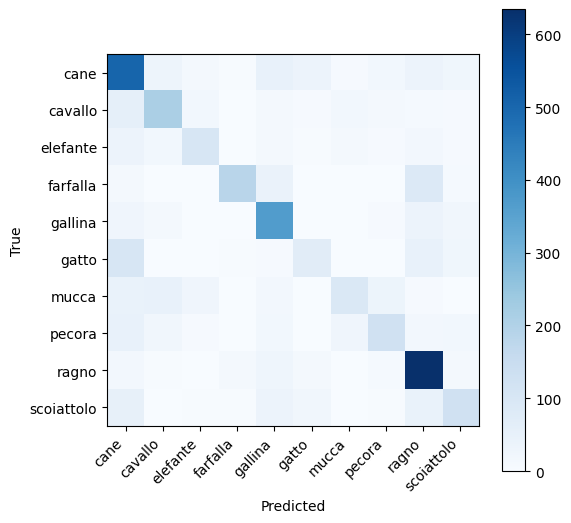

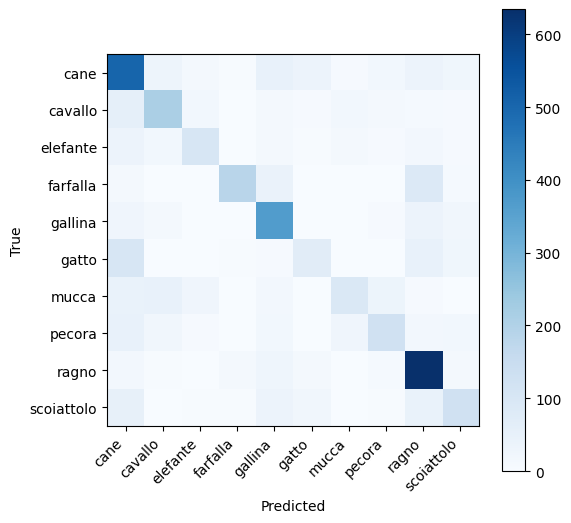

In [4]:
metrics = evaluate(state, Xs['test'], ys['test'], class_names)
fig = plot_confusion_matrix(metrics['confusion_matrix'], class_names)
fig.savefig(EVAL_DIR / 'confusion_matrix.png', bbox_inches='tight')
fig


## Section 5 - Accuracy/Precision/Recall Bar Chart
Rather than reading numbers out loud, this cell renders a compact KPI chart and saves it as `outputs/evaluation/test_metrics.png`. 


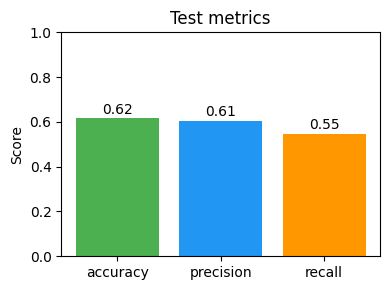

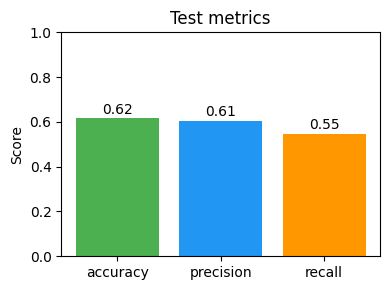

In [5]:
metric_values = {k: metrics[k] for k in ['accuracy', 'precision', 'recall']}
fig, ax = plt.subplots(figsize=(4, 3))
bars = ax.bar(metric_values.keys(), metric_values.values(), color=['#4caf50', '#2196f3', '#ff9800'])
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Test metrics')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{bar.get_height():.2f}', ha='center')
fig.tight_layout()
fig.savefig(EVAL_DIR / 'test_metrics.png', bbox_inches='tight')
fig


## Section 6 - Hyper-parameter Sweep on a Subset
To experiment quickly, we reload the dataset with `limit_per_class=40`, which yields a balanced mini set of 400 images per split. The `tuning_grid` covers four scenarios (baseline, wider first kernel, lower dropout, lower learning rate). Each configuration trains for two epochs, logs validation accuracy/precision/recall, and appends the results to `tuning_results`. The resulting line plot (`outputs/hparam/hparam_tuning.png`) shows accuracy ranging from roughly 0.05 to 0.18 depending on the tweak.


INFO:JAX_wildlife_utils:Epoch 1/2 loss=3.2621 acc=0.1010 val_acc=0.1833
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2787 acc=0.1365 val_acc=0.1000
INFO:JAX_wildlife_utils:Epoch 1/2 loss=4.1174 acc=0.0865 val_acc=0.0500
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.3038 acc=0.1240 val_acc=0.1000
INFO:JAX_wildlife_utils:Epoch 1/2 loss=3.2035 acc=0.0969 val_acc=0.1333
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2909 acc=0.1271 val_acc=0.1333
INFO:JAX_wildlife_utils:Epoch 1/2 loss=2.7433 acc=0.0885 val_acc=0.1833
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2849 acc=0.1385 val_acc=0.1167


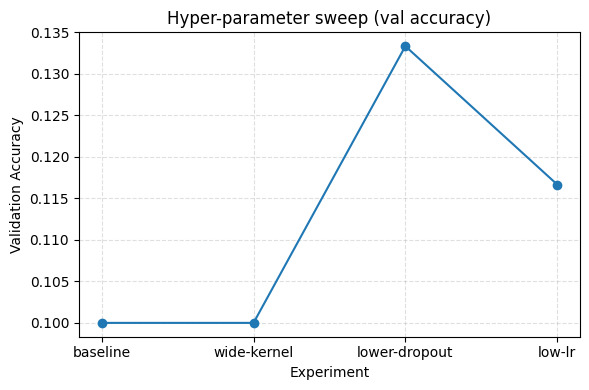

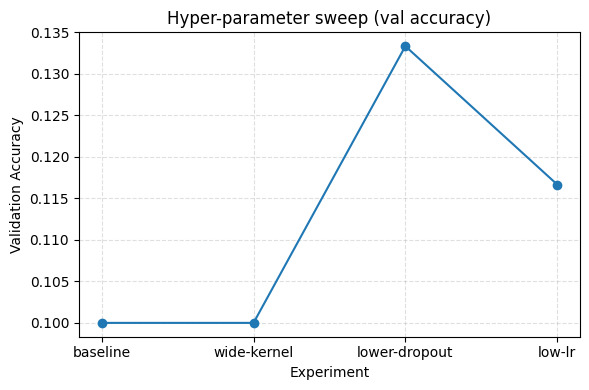

In [6]:
Xs_tune, ys_tune, _ = load_dataset(
    DATA_DIR, image_size=IMAGE_SIZE, splits=(0.7, 0.15, 0.15), limit_per_class=40
)
tuning_grid = [
    {"name": "baseline", "lr": 1e-3, "kernels": [(3, 3), (3, 3), (3, 3)], "dropout": 0.5},
    {"name": "wide-kernel", "lr": 1e-3, "kernels": [(5, 5), (3, 3), (3, 3)], "dropout": 0.5},
    {"name": "lower-dropout", "lr": 1e-3, "kernels": [(3, 3), (3, 3), (3, 3)], "dropout": 0.3},
    {"name": "low-lr", "lr": 5e-4, "kernels": [(3, 3), (3, 3), (3, 3)], "dropout": 0.5},
]
tuning_results = []
for cfg in tuning_grid:
    tune_config = TrainConfig(
        image_size=IMAGE_SIZE,
        num_classes=len(class_names),
        num_epochs=2,
        batch_size=64,
        learning_rate=cfg["lr"],
        conv_kernel_sizes=tuple(cfg["kernels"]),
        dropout_rate=cfg["dropout"],
    )
    state_tune, _ = train(Xs_tune["train"], ys_tune["train"], Xs_tune["val"], ys_tune["val"], tune_config)
    val_metrics = evaluate(state_tune, Xs_tune["val"], ys_tune["val"], class_names)
    tuning_results.append(
        {
            "name": cfg["name"],
            "learning_rate": cfg["lr"],
            "kernels": cfg["kernels"],
            "dropout": cfg["dropout"],
            "val_accuracy": val_metrics["accuracy"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
        }
    )
tuning_results

names = [cfg['name'] for cfg in tuning_grid]
val_acc = [result['val_accuracy'] for result in tuning_results]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(names, val_acc, marker='o')
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel('Experiment')
ax.set_title('Hyper-parameter sweep (val accuracy)')
ax.grid(True, linestyle='--', alpha=0.4)
fig.tight_layout()
fig.savefig(HPARAM_DIR / 'hparam_tuning.png', bbox_inches='tight')
fig


## Section 7 - Per-Configuration Confusion Matrices
Numbers alone do not explain which classes benefit from a tweak, so this section retrains each configuration and saves `confusion_baseline.png`, `confusion_wide-kernel.png`, etc. The matrices reveal patterns such as "low learning rate collapses to one dominant class" versus "wider kernels spread predictions across more species."


In [7]:
# Save confusion matrices per tuning config
for cfg in tuning_grid:
    tune_config = TrainConfig(
        image_size=IMAGE_SIZE,
        num_classes=len(class_names),
        num_epochs=2,
        batch_size=64,
        learning_rate=cfg['lr'],
        conv_kernel_sizes=tuple(cfg['kernels']),
        dropout_rate=cfg['dropout'],
    )
    state_cfg, _ = train(Xs_tune['train'], ys_tune['train'], Xs_tune['val'], ys_tune['val'], tune_config)
    val_metrics_cfg = evaluate(state_cfg, Xs_tune['val'], ys_tune['val'], class_names)
    fig = plot_confusion_matrix(val_metrics_cfg['confusion_matrix'], class_names)
    filename = HPARAM_DIR / f'confusion_{cfg["name"]}.png'
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)
print('Saved per-configuration confusion matrices under outputs/hparam/.')


INFO:JAX_wildlife_utils:Epoch 1/2 loss=3.2621 acc=0.1010 val_acc=0.1833
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2787 acc=0.1365 val_acc=0.1000
INFO:JAX_wildlife_utils:Epoch 1/2 loss=4.1174 acc=0.0865 val_acc=0.0500
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.3038 acc=0.1240 val_acc=0.1000
INFO:JAX_wildlife_utils:Epoch 1/2 loss=3.2035 acc=0.0969 val_acc=0.1333
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2909 acc=0.1271 val_acc=0.1333
INFO:JAX_wildlife_utils:Epoch 1/2 loss=2.7433 acc=0.0885 val_acc=0.1833
INFO:JAX_wildlife_utils:Epoch 2/2 loss=2.2849 acc=0.1385 val_acc=0.1167


Saved per-configuration confusion matrices under outputs/hparam/.


## Section 8 - Misclassified Examples
`sample_misclassifications` pulls a grid of mistakes from the full test split and saves it to `outputs/evaluation/misclassifications.png`. Most of the highlighted failures are low-light frames or cases where two animals share a similar color palette (e.g., deer vs horse).


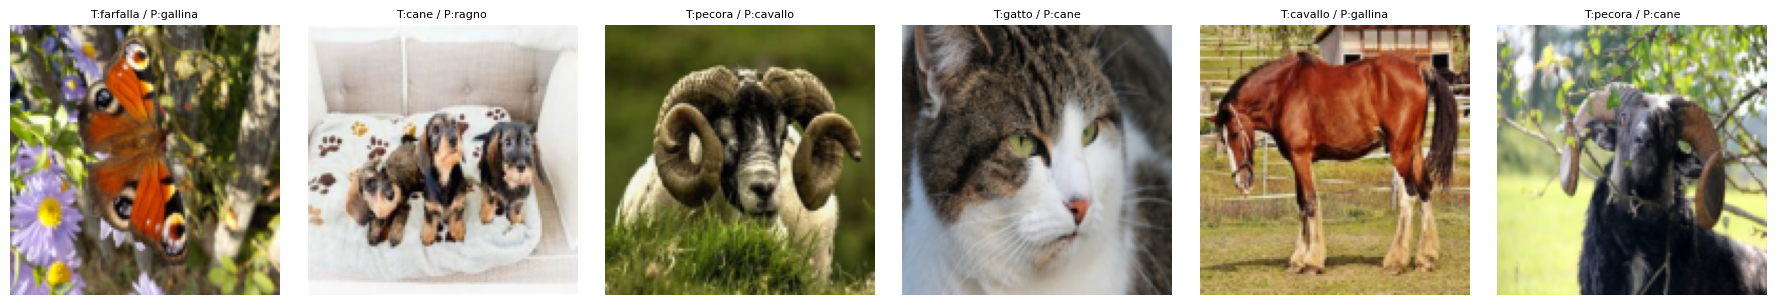

In [8]:
images, y_true, y_pred = sample_misclassifications(Xs['test'], ys['test'], metrics['y_pred'], k=6)
if len(images) > 0:
    fig, axes = plt.subplots(1, len(images), figsize=(3 * len(images), 3))
    if len(images) == 1:
        axes = [axes]
    for ax, img, yt, yp in zip(axes, images, y_true, y_pred):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'T:{class_names[yt]} / P:{class_names[yp]}', fontsize=8)
    fig.tight_layout()
    fig.savefig(EVAL_DIR / 'misclassifications.png', bbox_inches='tight')
    fig
else:
    print('No misclassifications in sampled subset.')


## Section 9 - Correctly Classified Examples
This cell grabs confident predictions and writes `outputs/evaluation/correct_examples.png`. The grid usually features crisp daytime shots where the animal is centered, underscoring that the model does capture useful texture and shape cues even without augmentation. Pairing this with the misclassification grid provides a complete qualitative picture.


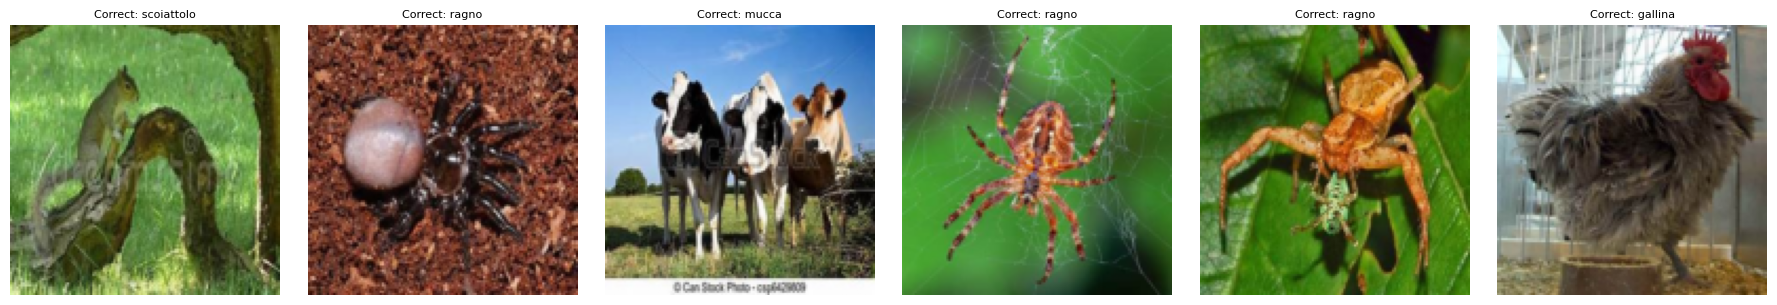

In [9]:
correct_idx = np.where(metrics['y_pred'] == ys['test'])[0]
if len(correct_idx) > 0:
    take = correct_idx[: min(6, len(correct_idx))]
    fig, axes = plt.subplots(1, len(take), figsize=(3 * len(take), 3))
    if len(take) == 1:
        axes = [axes]
    for ax, idx in zip(axes, take):
        ax.imshow(Xs['test'][idx])
        ax.axis('off')
        label = class_names[ys['test'][idx]]
        ax.set_title(f"Correct: {label}", fontsize=8)
    fig.tight_layout()
    fig.savefig(EVAL_DIR / 'correct_examples.png', bbox_inches='tight')
    fig
else:
    print('No correct predictions detected in sample.')
